# Exploratory Data Analysis (EDA)
Looking into the data of weather and train disruptions to see if there are any patterns or trends that can be found.

In [62]:
import pandas as pd
import requests
import seaborn as sns
from pyspark.sql.functions import col

In [58]:
def get_historical_weather(
    lat=52.377956,
    lon=4.897070,
    start_date="2022-01-01",
    end_date="2022-12-31",
    feature_list=[
        "temperature_2m",
        "relativehumidity_2m",
        "windspeed_10m",
        "rain",
    ],
):
    """
    Get historical weather data from open-meteo.com

    Parameters
    ----------
    lat: float
        Latitude of the location you want to get the weather for.
    lon: float
        Longitude of the location you want to get the weather for.
    start_date: str
        Start date of the period you want to get the weather for.
    end_date: str
        End date of the period you want to get the weather for.
    feature_list: list
        List of features you want to get the weather for.
        Options: "temperature_2m", "relativehumidity_2m",
        "windspeed_10m", "rain"

    Returns
    -------
    df: pd.DataFrame
        Data frame containing the weather data.

    Examples
    --------
    >>> import pandas as pd
    >>> from utils import get_historical_weather
    >>> df = get_historical_weather()
    >>> df.head()

    """
    url = f"https://archive-api.open-meteo.com/v1/era5?latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}&hourly={','.join(feature_list)}"
    response = requests.get(url)
    return pd.DataFrame(response.json()["hourly"])

In [65]:
train_df = (
    spark.read.load("dbfs:/user/hive/warehouse/disruptions_2011_2021")
    .withColumn("start_time", col("start_time").cast("string"))
    .withColumn("end_time", col("end_time").cast("string"))
    .toPandas()
    .assign(
        **{
            "start_time": lambda x: pd.to_datetime(x["start_time"]),
            # "end_time": lambda x: pd.to_datetime(x["end_time"]),
            "date": lambda x: pd.to_datetime(x["start_time"]).dt.date,
        }
    )
    .groupby("date")
    .agg({"duration_minutes": "sum"})
    # .reset_index()
)

In [66]:
weather_df = (
    get_historical_weather(
        lat=52.520008,
        lon=13.404954,
        start_date=str(train_df.index.min()),
        end_date=str(train_df.index.max()),
    )
    .assign(**{"date": lambda x: pd.to_datetime(x["time"]).dt.date})
    .groupby("date")
    .agg({"temperature_2m": ["mean", "min", "max"], "rain": "sum"})
)
weather_df.columns = ["_".join(col) for col in weather_df.columns]

In [68]:
df = (pd.merge(train_df, weather_df, on="date", how="left")
      .loc[lambda x: x["duration_minutes"] < 20000] # remove outliers
      .dropna()
      )

In [69]:
df.dtypes

Out[65]: duration_minutes       float64
temperature_2m_mean    float64
temperature_2m_min     float64
temperature_2m_max     float64
rain_sum               float64
dtype: object

In [70]:
display(df.head(2))

duration_minutes,temperature_2m_mean,temperature_2m_min,temperature_2m_max,rain_sum
132,-2.4291666666666667,-2.9,-1.7,0
1022,-1.6083333333333334,-3.5,-0.3,0


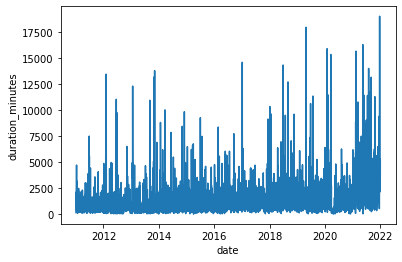

In [74]:
_ = sns.lineplot(data=df, x="date", y="duration_minutes")

In [75]:
df.corr()

,duration_minutes,temperature_2m_mean,temperature_2m_min,temperature_2m_max,rain_sum
duration_minutes,1.000000,0.001230,-0.004070,0.003735,0.007548
temperature_2m_mean,0.001230,1.000000,0.971811,0.986060,0.104311
temperature_2m_min,-0.004070,0.971811,1.000000,0.927008,0.167871
temperature_2m_max,0.003735,0.986060,0.927008,1.000000,0.064131
rain_sum,0.007548,0.104311,0.167871,0.064131,1.000000
